In [1]:
import pandas as pd
import janitor
import gc
from utilities.utils import get_fulldata
from utilities.graph_utils import save_mpl_fig
from utilities.graph_utils import pandas_to_tex
import matplotlib.pyplot as plt
import matplotlib as mpl
from forestplot import forestplot
import seaborn as sns
import matplotlib.ticker as mtick
import warnings
warnings.filterwarnings('ignore')

HINDI_NAMES = '../data/hindi_names_religion.csv.gz'

usecols = ['account_no', '6', '7', '8']
df = (get_fulldata(**{'usecols':usecols})
      .assign(tt_area_acre=lambda df: df['6']+df['7']/100+df['8']*2.4711)
      .remove_columns(['6', '7', '8'])
      .query("tt_area_acre>0")
     )
df.shape

(38897910, 2)

In [2]:
df.head()

,account_no,tt_area_acre
0,701010001000008,8.525
1,701010001000003,0.560
5,701010001000014,0.320
7,701010001000019,0.540
10,701010001000027,0.630


### Prep intermediate data for number of plots and area of plots

In [3]:
nplots_by_account = (df
                     .groupby('account_no').size().reset_index()
                     .rename_column(0, 'nplots')
                    )
print(f'{len(nplots_by_account)=:,}')
print(nplots_by_account.head(3))

len(nplots_by_account)=12,031,744
        account_no  nplots
0  101010273000001       2
1  101010273000002       8
2  101010273000003       1


In [4]:
landarea_by_account = (df
                       .groupby('account_no')
                       .sum().reset_index()
                       .query('tt_area_acre>0')
                      )
print(f'{len(landarea_by_account)=:,}')
print(landarea_by_account.head(3))

len(landarea_by_account)=12,031,744
        account_no  tt_area_acre
0  101010273000001         0.585
1  101010273000002         1.545
2  101010273000003         0.080


### Skew in Number of plots per account holder

In [5]:
# Get table of percentiles (fold cell)
ntiles = [.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.96,.97,.98,.99,1]
tab_nplot_deciles = (nplots_by_account
                     .nplots.quantile(ntiles)
                     .reset_index()
                     .rename_column('index', 'Percentile')
                     .astype({"nplots":int})
                    )
pandas_to_tex(tab_nplot_deciles, "../tables/percentiles_landplots_per_accountholder")
tab_nplot_deciles

,Percentile,nplots
0,0.00,1
1,0.10,1
2,0.20,1
3,0.30,1
4,0.40,1
5,0.50,1
6,0.60,1
7,0.70,2
8,0.80,3
9,0.90,7


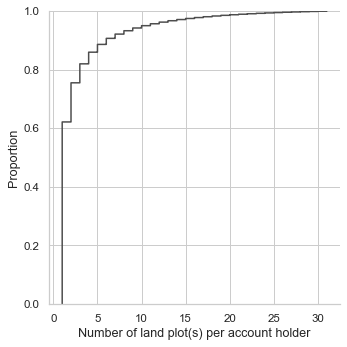

In [6]:
# Empirical CDF of #plots owned per account (fold cell)
sns.displot(x="nplots", 
            data=nplots_by_account.query(f"nplots<={nplots_by_account.nplots.quantile(.99)}"), 
            color="0.3",
            kind="ecdf"
           )
plt.xlabel("Number of land plot(s) per account holder")
save_mpl_fig('../figures/number_plots_per_accountholder_ecdf')

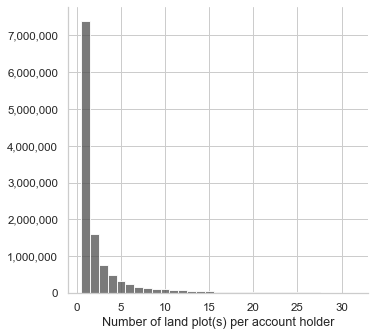

In [7]:
# Histogram of #plots owned per account (fold cell)
ax = sns.displot(data=nplots_by_account.query(f"nplots<={nplots_by_account.nplots.quantile(.99)}"), 
            x="nplots", 
            kind='hist',
            discrete=True,
            color=".3",
           )
ax.set_xlabels("Number of land plot(s) per account holder")
ax.set_ylabels("")
# https://stackoverflow.com/questions/39376888/how-to-separate-thousands-with-commas-using-facet-grid-in-seaborn
for _ax in ax.axes[:,0]:
    _ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
save_mpl_fig('../figures/number_plots_per_accountholder_histogram')    

### Skew in area of plot(s) owned per account holder

In [8]:
# Get table of percentiles (fold cell)
ntiles = [.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.96,.97,.98,.99,1]
tab_acres_deciles = (landarea_by_account
                     .tt_area_acre.quantile(ntiles)
                     .reset_index()
                     .rename_column('index', 'Percentile')
                     .round(decimals=2)
                    )
pandas_to_tex(tab_acres_deciles, "../tables/percentiles_landarea_per_accountholder")
tab_acres_deciles

,Percentile,tt_area_acre
0,0.00,0.00
1,0.10,0.04
2,0.20,0.08
3,0.30,0.14
4,0.40,0.22
5,0.50,0.34
6,0.60,0.51
7,0.70,0.80
8,0.80,1.31
9,0.90,2.74


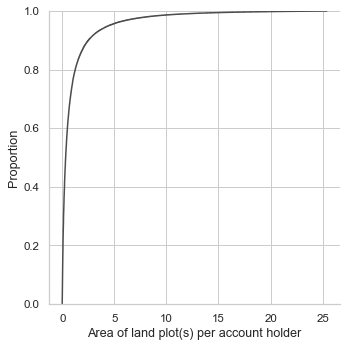

In [9]:
# Empirical CDF of land plot area owned per account (fold cell)
sns.displot(x="tt_area_acre", 
            data=landarea_by_account.query(f"tt_area_acre<={landarea_by_account.tt_area_acre.quantile(.99)}"), 
            color="0.3",
            kind="ecdf"
           )
plt.xlabel("Area of land plot(s) per account holder")
save_mpl_fig('../figures/plot_area_per_accountholder_ecdf')    

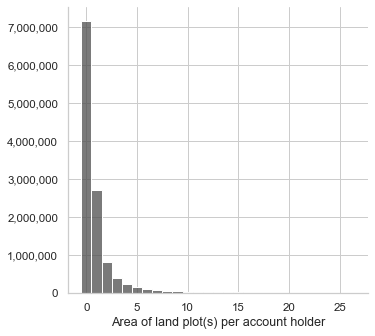

In [10]:
# Histogram of land plot area owned per account (fold cell)
ax = sns.displot(data=landarea_by_account.query(f"tt_area_acre<={landarea_by_account.tt_area_acre.quantile(.99)}"), 
            x="tt_area_acre", 
            kind='hist',
            discrete=True,
            color=".3",
           )
ax.set_xlabels("Area of land plot(s) per account holder")
ax.set_ylabels("")
# https://stackoverflow.com/questions/39376888/how-to-separate-thousands-with-commas-using-facet-grid-in-seaborn
for _ax in ax.axes[:,0]:
    _ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
save_mpl_fig('../figures/plot_area_per_accountholder_histogram')        

### Skew in area per plot owned per account holder

In [11]:
df_land_per_plot = (landarea_by_account
                    .merge(nplots_by_account, 
                           how="left", on=["account_no"], validate="1:1")
                    .assign(land_per_plot=lambda df: df.tt_area_acre/df.nplots)
                   )
df_land_per_plot.head(3)

,account_no,tt_area_acre,nplots,land_per_plot
0,101010273000001,0.585,2,0.292500
1,101010273000002,1.545,8,0.193125
2,101010273000003,0.080,1,0.080000


In [12]:
# Get table of percentiles (fold cell)
ntiles = [.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.96,.97,.98,.99,1]
tab_acresperplot_deciles = (df_land_per_plot
                            .land_per_plot.quantile(ntiles)
                            .reset_index()
                            .rename_column('index', 'Percentile')
                            .round(decimals=2)
                           )
pandas_to_tex(tab_acresperplot_deciles, "../tables/percentiles_landarea_per_plot_per_accountholder")
tab_acresperplot_deciles

,Percentile,land_per_plot
0,0.00,0.00
1,0.10,0.03
2,0.20,0.06
3,0.30,0.10
4,0.40,0.14
5,0.50,0.19
6,0.60,0.26
7,0.70,0.37
8,0.80,0.56
9,0.90,1.03


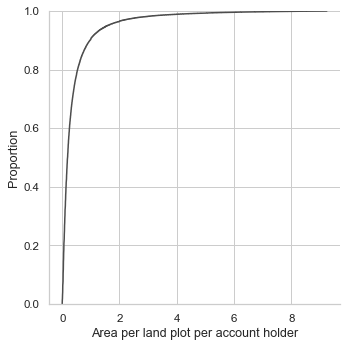

In [13]:
# Empirical CDF of land per area owned per account (fold cell)
sns.displot(x="land_per_plot", 
            data=df_land_per_plot.query(f"land_per_plot<={df_land_per_plot.land_per_plot.quantile(.99)}"), 
            color="0.3",
            kind="ecdf"
           )
plt.xlabel("Area per land plot per account holder")
save_mpl_fig('../figures/landarea_per_plot_per_accountholder_ecdf')    

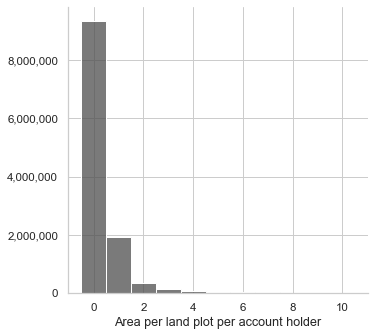

In [14]:
# Histogram of land plot area owned per account (fold cell)
ax = sns.displot(data=df_land_per_plot.query(f"land_per_plot<={df_land_per_plot.land_per_plot.quantile(.99)}"), 
                 x="land_per_plot", 
                 kind='hist',
                 discrete=True,
                 color=".3",
                )
ax.set_xlabels("Area per land plot per account holder")
ax.set_ylabels("")
# https://stackoverflow.com/questions/39376888/how-to-separate-thousands-with-commas-using-facet-grid-in-seaborn
for _ax in ax.axes[:,0]:
    _ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
save_mpl_fig('../figures/landarea_per_plot_per_accountholder_histogram')        

### Common last names of land owners in registry

In [15]:
df_name = (pd.read_csv('../data/hindi_names_religion_translated.csv.gz')
           .dropna(subset="eng_name")
           .assign(last_name=lambda df: [name.split(" ")[-1].title() for name in df.eng_name])
           .groupby(["last_name", "pred_label"]).size().reset_index()
           .rename_column(0, "count")
           .sort_values("count", ascending=False, ignore_index=True)
           .assign(moe=0)
           .assign(pred_label=lambda df: df.pred_label.str.title())
           .assign(count_str=lambda df: df.apply(lambda x: "{:,}".format(x['count']), axis=1))
           .assign(count_str=lambda df: df.count_str.apply(lambda x: x.rjust(7) if len(x)<7 else x))
           .assign(pred_label=lambda df: df.pred_label.apply(lambda x: x.rjust(10) if len(x)<10 else x))
          )
df_name.head(30)

,last_name,pred_label,count,moe,count_str
0,Devi,Not-Muslim,172507,0,"172,507"
1,Singh,Not-Muslim,121827,0,"121,827"
2,Yadavas,Not-Muslim,113381,0,"113,381"
3,Siha,Not-Muslim,68161,0,"68,161"
4,Sah,Not-Muslim,66308,0,"66,308"
5,Ray,Not-Muslim,64250,0,"64,250"
6,Mahato,Not-Muslim,62392,0,"62,392"
7,Mandal,Not-Muslim,60880,0,"60,880"
8,Khatun,Muslim,38940,0,"38,940"
9,Thakur,Not-Muslim,35708,0,"35,708"


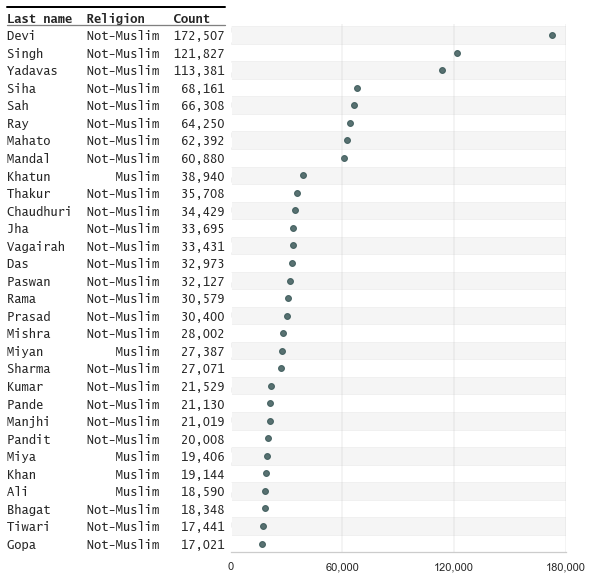

In [16]:
# Plot (fold cell)
ax = forestplot(df_name.head(30), 
                estimate="count", 
                moerror="moe", 
                varlabel="last_name", 
                xticks=[0,60_000, 120_000,180_000],
                annote=["pred_label", "count_str"],
                annoteheaders=["Religion", "Count"],
                ci_report=False,
                figsize=(6,10),
                color_alt_rows=True,
                table=True,
               **{"marker": "o",  # set maker symbol as diamond
                  "variable_header": "Last name",
                  "markersize": 35,  # adjust marker size
                  "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
                  "xlinecolor": "1",  # gray color for x-reference line
                  "xtick_size": 11,  # adjust x-ticker fontsize
                 }   
               )
ax.xaxis.set_ticks_position('none') 
ax.grid(False)
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick) 
for vline in [60_000, 120_000, 180_000]:
    ax.vlines(vline, ymin=-.5, ymax=29.6, colors=".6", linewidth=.2)
save_mpl_fig('../figures/30_most_common_lastnames_accountholders')        

In [17]:
# import winsound
# frequency = 2500  # Set Frequency To 2500 Hertz
# duration = 1000  # Set Duration To 1000 ms == 1 second
# winsound.Beep(frequency, duration)